In [1]:
import numpy as np
from scipy.special import hankel1 as besselh
from scipy.special import iv as besseli
from scipy.special import kv as besselk
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from math import sqrt, cosh, cos, sinh, sin, pi
from scipy.optimize import newton, minimize_scalar
from multi_constants import *
from multi_equations import *
import pandas as pd

In [2]:
boundary_count = len(NMK) - 1
for arr in [a, d, heaving]:
    assert len(arr) == boundary_count, "NMK should have one more entry than a, d, and heaving, which should all have the same number of entries."

for entry in heaving:
    assert (entry == 0 or entry == 1), "heaving entries should be booleans."

left = 0
for radius in a:
    assert radius > left, "a entries should be increasing, and start greater than 0."
    left = radius

for depth in d:
    assert depth >= 0, "d entries should be nonnegative."
    assert depth < h, "d entries should be less than h."

for val in NMK:
    assert (type(val) == int and val > 0), "NMK entries should be positive integers."

assert (m0 >= 0), "m0 should be nonnegative." # currently shouldn't be 0 or too large, but that will be fixed eventually


In [3]:
# CREATING THE A MATRIX
size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
boundary_count = len(NMK) - 1

rows = [] # collection of rows of blocks in A matrix, to be concatenated later

## Define values/functions to help block creation
#Coupling integral values
I_nm_vals = np.zeros((max(NMK), max(NMK), boundary_count - 1), dtype = complex)
for bd in range(boundary_count - 1):
    for n in range(NMK[bd]):
        for m in range(NMK[bd + 1]):
            I_nm_vals[n][m][bd] = I_nm(n, m, bd)
I_mk_vals = np.zeros((NMK[boundary_count - 1], NMK[boundary_count]), dtype = complex)
for m in range(NMK[boundary_count - 1]):
    for k in range(NMK[boundary_count]):
        I_mk_vals[m][k]= I_mk(m, k, boundary_count - 1)

## Functions to create blocks of certain types
# arguments: diagonal block on left (T/F), vectorized radial eigenfunction, boundary number
def p_diagonal_block(left, radfunction, bd):
    region = bd if left else (bd + 1)
    sign = 1 if left else (-1)
    return sign * (h - d[region]) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))
    
# arguments: dense block on left (T/F), vectorized radial eigenfunction, boundary number
def p_dense_block(left, radfunction, bd):
    I_nm_array = I_nm_vals[0:NMK[bd],0:NMK[bd+1], bd]
    if left: # determine which is region to work in and which is adjacent
        region, adj = bd, bd + 1
        sign = 1
        I_nm_array = np.transpose(I_nm_array)
    else:
        region, adj = bd + 1, bd
        sign = -1
    radial_vector = radfunction(list(range(NMK[region])), a[bd], region)
    radial_array = np.outer((np.full((NMK[adj]), 1)), radial_vector)
    return sign * radial_array * I_nm_array

def p_dense_block_e(bd):
    I_mk_array = I_mk_vals
    radial_vector = (np.vectorize(Lambda_k))(list(range(NMK[bd+1])), a[bd])
    radial_array = np.outer((np.full((NMK[bd]), 1)), radial_vector)
    return (-1) * radial_array * I_mk_array

#####
# arguments: diagonal block on left (T/F), vectorized radial eigenfunction, boundary number
def v_diagonal_block(left, radfunction, bd):
    region = bd if left else (bd + 1)
    sign = (-1) if left else (1)
    return sign * (h - d[region]) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))

# arguments: dense block on left (T/F), vectorized radial eigenfunction, boundary number
def v_dense_block(left, radfunction, bd):
    I_nm_array = I_nm_vals[0:NMK[bd],0:NMK[bd+1], bd]
    if left: # determine which is region to work in and which is adjacent
        region, adj = bd, bd + 1
        sign = -1
        I_nm_array = np.transpose(I_nm_array)
    else:
        region, adj = bd + 1, bd
        sign = 1
    radial_vector = radfunction(list(range(NMK[region])), a[bd], region)
    radial_array = np.outer((np.full((NMK[adj]), 1)), radial_vector)
    return sign * radial_array * I_nm_array

def v_diagonal_block_e(bd):
    return h * np.diag((np.vectorize(diff_Lambda_k))(list(range(NMK[bd+1])), a[bd]))

def v_dense_block_e(radfunction, bd): # for region adjacent to e-type region
    I_km_array = np.transpose(I_mk_vals)
    radial_vector = radfunction(list(range(NMK[bd])), a[bd], bd)
    radial_array = np.outer((np.full((NMK[bd + 1]), 1)), radial_vector)
    return (-1) * radial_array * I_km_array


In [4]:
# Potential Blocks
col = 0
for bd in range(boundary_count):
    N = NMK[bd]
    M = NMK[bd + 1]
    if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
        row_height = N
        left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
        right_block = p_dense_block_e(bd)
        if bd == 0: # one cylinder
            rows.append(np.concatenate((left_block1,right_block), axis = 1))
        else:
            left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
            left_zeros = np.zeros((row_height, col), dtype=complex)
            rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
    elif bd == 0:
        left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            row_height = N
            left_block = p_diagonal_block(True, np.vectorize(R_1n), 0)
            right_block1 = p_dense_block(False, np.vectorize(R_1n), 0)
            right_block2 = p_dense_block(False, np.vectorize(R_2n), 0)
        else:
            row_height = M
            left_block = p_dense_block(True, np.vectorize(R_1n), 0)
            right_block1 = p_diagonal_block(False, np.vectorize(R_1n), 0)
            right_block2 = p_diagonal_block(False, np.vectorize(R_2n), 0)
        right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
        block_lst = [left_block, right_block1, right_block2, right_zeros]
        rows.append(np.concatenate(block_lst, axis = 1))
        col += N
    else: # i-i boundary
        left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
        if left_diag:
            row_height = N
            left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
            left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
            right_block1 = p_dense_block(False, np.vectorize(R_1n),  bd)
            right_block2 = p_dense_block(False, np.vectorize(R_2n),  bd)
        else:
            row_height = M
            left_block1 = p_dense_block(True, np.vectorize(R_1n),  bd)
            left_block2 = p_dense_block(True, np.vectorize(R_2n),  bd)
            right_block1 = p_diagonal_block(False, np.vectorize(R_1n),  bd)
            right_block2 = p_diagonal_block(False, np.vectorize(R_2n),  bd)
        left_zeros = np.zeros((row_height, col), dtype=complex)
        right_zeros = np.zeros((row_height, size - (col + 2 * N + 2 * M)),dtype=complex)
        block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
        rows.append(np.concatenate(block_lst, axis = 1))
        col += 2 * N


###############################
# Velocity Blocks
col = 0
for bd in range(boundary_count):
    N = NMK[bd]
    M = NMK[bd + 1]
    if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
        row_height = M
        left_block1 = v_dense_block_e(np.vectorize(diff_R_1n, otypes=[complex]), bd)
        right_block = v_diagonal_block_e(bd)
        if bd == 0: # one cylinder
            rows.append(np.concatenate((left_block1,right_block), axis = 1))
        else:
            left_block2 = v_dense_block_e(np.vectorize(diff_R_2n, otypes=[complex]), bd)
            left_zeros = np.zeros((row_height, col), dtype=complex)
            rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
    elif bd == 0:
        left_diag = d[bd] < d[bd + 1] # taller fluid region gets diagonal entries
        if left_diag:
            row_height = N
            left_block = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0)
            right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0)
            right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0)
        else:
            row_height = M
            left_block = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0)
            right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0)
            right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0)
        right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
        block_lst = [left_block, right_block1, right_block2, right_zeros]
        rows.append(np.concatenate(block_lst, axis = 1))
        col += N
    else: # i-i boundary
        left_diag = d[bd] < d[bd + 1] # taller fluid region gets diagonal entries
        if left_diag:
            row_height = N
            left_block1 = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), bd)
            left_block2 = v_diagonal_block(True, np.vectorize(diff_R_2n, otypes=[complex]), bd)
            right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
            right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
        else:
            row_height = M
            left_block1 = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
            left_block2 = v_dense_block(True, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
            right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
            right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
        left_zeros = np.zeros((row_height, col), dtype=complex)
        right_zeros = np.zeros((row_height, size - (col + 2* N + 2 * M)),dtype=complex)
        block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
        rows.append(np.concatenate(block_lst, axis = 1))
        col += 2 * N

## Concatenate the rows of blocks into the square A matrix
A = np.concatenate(rows, axis = 0)

###########################################################################
# This plots a sparsity matrix
if False:
    
 rows, cols = np.nonzero(A)
 plt.figure(figsize=(6, 6))
 plt.scatter(cols, rows, color='blue', marker='o', s=100) 
 plt.gca().invert_yaxis() 
 plt.xticks(range(A.shape[1]))
 plt.yticks(range(A.shape[0]))

 cols = [NMK[0]]
 for i in range(1, boundary_count):
    cols.append(cols[-1] + NMK[i])
    cols.append(cols[-1] + NMK[i])
 cols.append(cols[-1] + NMK[-1])

 for val in cols:
    plt.axvline(val-0.5, color='black', linestyle='-', linewidth=1) 
    plt.axhline(val-0.5, color='black', linestyle='-', linewidth=1) 

 # for y in range(0, A.shape[0], 3):
    # plt.axhline(y-0.5, color='black', linestyle='-', linewidth=1) 

 plt.grid(True)
 plt.title('Non-Zero Entries of the Matrix')
 plt.xlabel('Column Index')
 plt.ylabel('Row Index')
 plt.show()


In [5]:
b = np.zeros(size, dtype=complex)

index = 0

# potential matching
for boundary in range(boundary_count):
    if boundary == (boundary_count - 1): # i-e boundary
        for n in range(NMK[-2]):
            b[index] = b_potential_end_entry(n, boundary)
            index += 1
    else: # i-i boundary
        for n in range(NMK[boundary + (d[boundary] < d[boundary + 1])]): # iterate over eigenfunctions for smaller h-d
            b[index] = b_potential_entry(n, boundary)
            index += 1

# velocity matching
for boundary in range(boundary_count):
    if boundary == (boundary_count - 1): # i-e boundary
        for n in range(NMK[-1]):
            b[index] = b_velocity_end_entry(n, boundary)
            index += 1
    else: # i-i boundary
        for n in range(NMK[boundary + (d[boundary] > d[boundary + 1])]): # iterate over eigenfunctions for larger h-d
            b[index] = b_velocity_entry(n, boundary)
            index += 1

In [6]:
X = linalg.solve(A,b)

In [7]:
# The c-vector dotted with X is the hydro coefficient integral (+ a constant, sum(hydro_p_terms))
c = np.zeros((size - NMK[-1]), dtype=complex)
col = 0
for n in range(NMK[0]):
    c[n] = heaving[0] * int_R_1n(0, n)* z_n_d(n)
col += NMK[0]
for i in range(1, boundary_count):
    M = NMK[i]
    for m in range(M):
        c[col + m] = heaving[i] * int_R_1n(i, m)* z_n_d(m)
        c[col + M + m] = heaving[i] * int_R_2n(i, m)* z_n_d(m)
    col += 2 * M

hydro_p_terms = np.zeros(boundary_count, dtype=complex)
for i in range(boundary_count):
    hydro_p_terms[i] = heaving[i] * int_phi_p_i(i)

hydro_coef = 2 * pi * (np.dot(c, X[:-NMK[-1]]) + sum(hydro_p_terms))
hydro_coef_real = hydro_coef.real * h**3 * rho
hydro_coef_imag = hydro_coef.imag * omega * h**3 * rho

# find maximum heaving radius
max_rad = a[0]
for i in range(boundary_count - 1, 0, -1):
    if heaving[i]:
        max_rad = a[i]
        break

hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef

print("real (added mass):", hydro_coef_real)
print("imag (damping):", hydro_coef_imag)
print("real/(h^3):", hydro_coef_real/(h**3)) # to compare with Capytaine
print("imag/(h^3):", hydro_coef_imag/(h**3))
print("nondimensional, real:", hydro_coef_nondim.real)
print("nondimensional, imag (no omega factor):", hydro_coef_nondim.imag)

# print("ratio", hydro_coef_real/hydro_coef_imag)

real (added mass): 1367585135364.0977
imag (damping): 204735461.28023225
real/(h^3): 1367585.1353640975
imag/(h^3): 204.73546128023224
nondimensional, real: 425528.7084891397
nondimensional, imag (no omega factor): 20.339162269721108


In [8]:
# Split up the Cs into groups depending on which equation they belong to.
Cs = []
row = 0
Cs.append(X[:NMK[0]])
row += NMK[0]
for i in range(1, boundary_count):
    Cs.append(X[row: row + NMK[i] * 2])
    row += NMK[i] * 2
Cs.append(X[row:])

In [9]:
def make_R_Z(sharp, spatial_res): # create coordinate array for graphing
    rmin = (2 * a[-1] / spatial_res) if sharp else 0.0
    r_vec = np.linspace(rmin, 2*a[-1], spatial_res)
    z_vec = np.linspace(0, -h, spatial_res)
    if sharp: # more precise near boundaries
        a_eps = 1.0e-4
        for i in range(len(a)):
            r_vec = np.append(r_vec, a[i]*(1-a_eps))
            r_vec = np.append(r_vec, a[i]*(1+a_eps))
        r_vec = np.unique(r_vec)
        for i in range(len(d)):
            z_vec = np.append(z_vec, -d[i])
        z_vec = np.unique(z_vec)
    return np.meshgrid(r_vec, z_vec)


In [10]:
def phi_h_n_inner_func(n, r, z):
    return (Cs[0][n] * R_1n(n, r, 0)) * Z_n_i(n, z, 0)

def phi_h_m_i_func(i, m, r, z):
    return (Cs[i][m] * R_1n(m, r, i) + Cs[i][NMK[i] + m] * R_2n(m, r, i)) * Z_n_i(m, z, i)

def phi_e_k_func(k, r, z):
    return Cs[-1][k] * Lambda_k(k, r) * Z_k_e(k, z)

R, Z = make_R_Z(True, 50)

regions = []
regions.append((R <= a[0]) & (Z < -d[0]))
for i in range(1, boundary_count):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
regions.append(R > a[-1])

phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

for n in range(NMK[0]):
    temp_phiH = phi_h_n_inner_func(n, R[regions[0]], Z[regions[0]])
    phiH[regions[0]] = temp_phiH if n == 0 else phiH[regions[0]] + temp_phiH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_phiH = phi_h_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        phiH[regions[i]] = temp_phiH if m == 0 else phiH[regions[i]] + temp_phiH

for k in range(NMK[-1]):
    temp_phiH = phi_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    phiH[regions[-1]] = temp_phiH if k == 0 else phiH[regions[-1]] + temp_phiH

phi_p_i_vec = np.vectorize(phi_p_i)

phiP[regions[0]] = heaving[0] * phi_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    phiP[regions[i]] = heaving[i] * phi_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
phiP[regions[-1]] = 0

phi = phiH + phiP

#nanregions = []
#nanregions.append((R <= a[0]) & (Z > -d[0]))
#for i in range(1, len(a)):
#    nanregions.append((R > a[i-1]) & (R <= a[i]) & (Z > -d[i]))


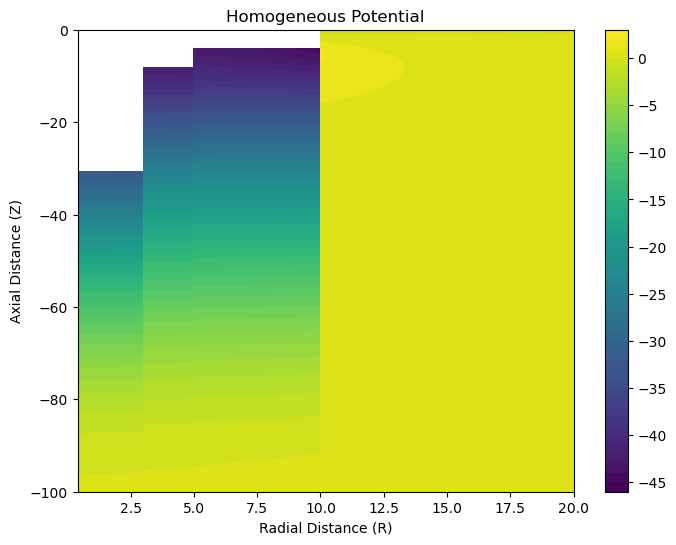

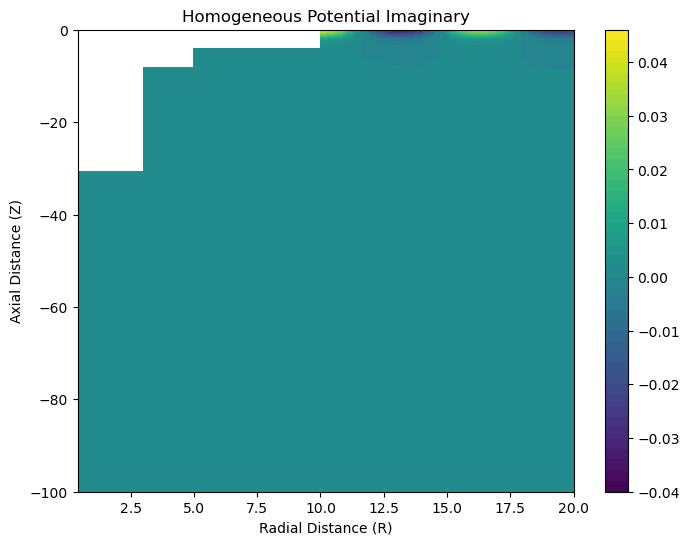

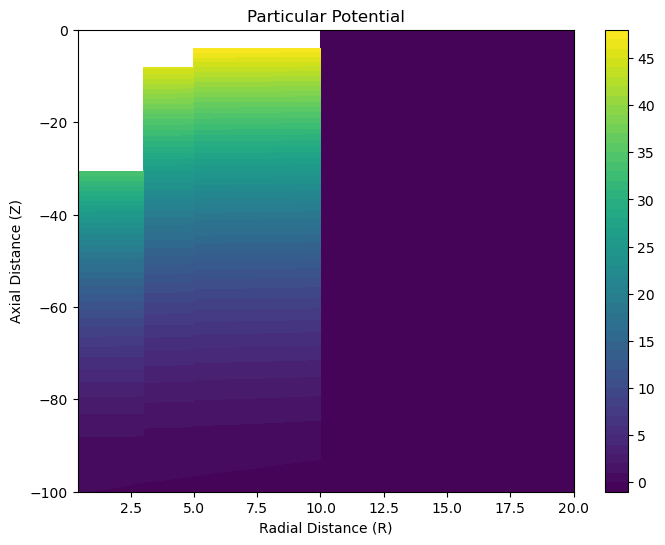

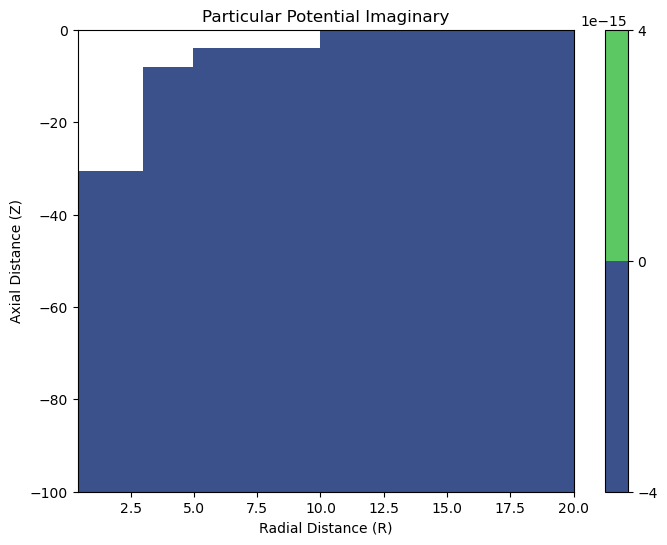

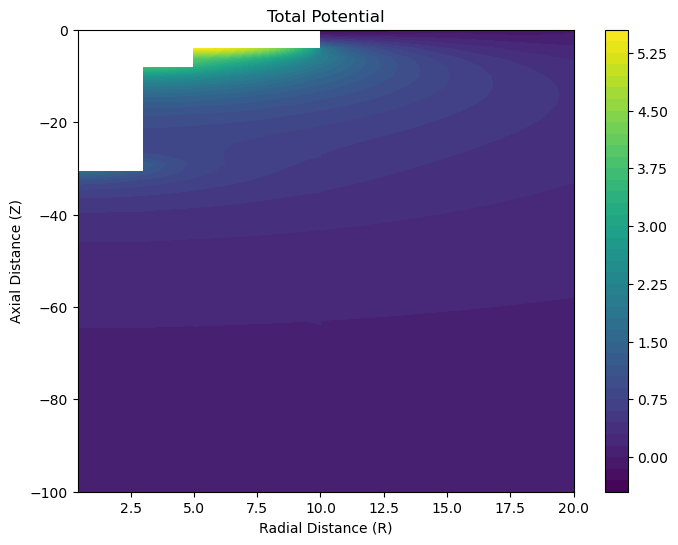

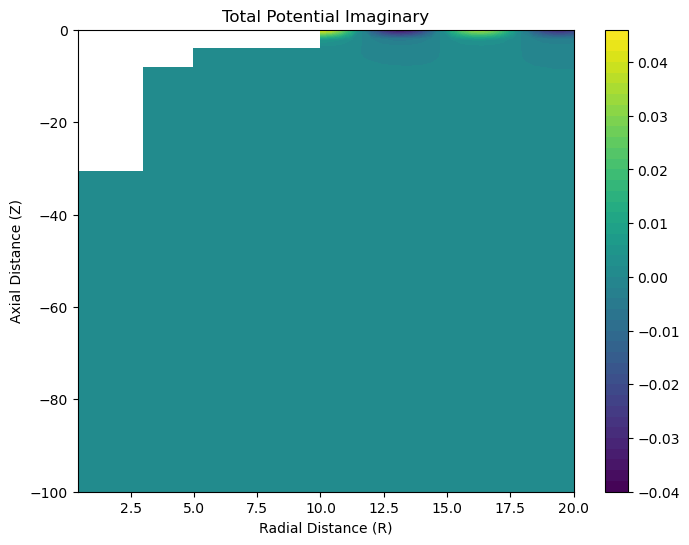

In [11]:
def plot_potential(field, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

plot_potential(np.real(phiH), R, Z, 'Homogeneous Potential')
plot_potential(np.imag(phiH), R, Z, 'Homogeneous Potential Imaginary')

plot_potential(np.real(phiP), R, Z, 'Particular Potential')
plot_potential(np.imag(phiP), R, Z, 'Particular Potential Imaginary')

plot_potential(np.real(phi), R, Z, 'Total Potential')
plot_potential(np.imag(phi), R, Z, 'Total Potential Imaginary')




In [12]:
def v_r_inner_func(n, r, z):
    return (Cs[0][n] * diff_R_1n(n, r, 0)) * Z_n_i(n, z, 0)

def v_r_m_i_func(i, m, r, z):
    return (Cs[i][m] * diff_R_1n(m, r, i) + Cs[i][NMK[i] + m] * diff_R_2n(m, r, i)) * Z_n_i(m, z, i)

def v_r_e_k_func(k, r, z):
    return Cs[-1][k] * diff_Lambda_k(k, r) * Z_k_e(k, z)

def v_z_inner_func(n, r, z):
    return (Cs[0][n] * R_1n(n, r, 0)) * diff_Z_n_i(n, z, 0)

def v_z_m_i_func(i, m, r, z):
    return (Cs[i][m] * R_1n(m, r, i) + Cs[i][NMK[i] + m] * R_2n(m, r, i)) * diff_Z_n_i(m, z, i)

def v_z_e_k_func(k, r, z):
    return Cs[-1][k] * Lambda_k(k, r) * diff_Z_k_e(k, z)

In [13]:
vr = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vrH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vrP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

vz = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vzH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
vzP = np.full_like(R, np.nan + np.nan*1j, dtype=complex)

for n in range(NMK[0]):
    temp_vrH = v_r_inner_func(n, R[regions[0]], Z[regions[0]])
    temp_vzH = v_z_inner_func(n, R[regions[0]], Z[regions[0]])
    if n == 0:
        vrH[regions[0]] = temp_vrH
        vzH[regions[0]] = temp_vzH
    else:
        vrH[regions[0]] = vrH[regions[0]] + temp_vrH
        vzH[regions[0]] = vzH[regions[0]] + temp_vzH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_vrH = v_r_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        temp_vzH = v_z_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        if m == 0:
            vrH[regions[i]] = temp_vrH
            vzH[regions[i]] = temp_vzH
        else:
            vrH[regions[i]] = vrH[regions[i]] + temp_vrH
            vzH[regions[i]] = vzH[regions[i]] + temp_vzH

for k in range(NMK[-1]):
    temp_vrH = v_r_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    temp_vzH = v_z_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    if k == 0:
        vrH[regions[-1]] = temp_vrH
        vzH[regions[-1]] = temp_vzH
    else:
        vrH[regions[-1]] = vrH[regions[-1]] + temp_vrH
        vzH[regions[-1]] = vzH[regions[-1]] + temp_vzH

vr_p_i_vec = np.vectorize(diff_r_phi_p_i)
vz_p_i_vec = np.vectorize(diff_z_phi_p_i)

vrP[regions[0]] = heaving[0] * vr_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
vzP[regions[0]] = heaving[0] * vz_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    vrP[regions[i]] = heaving[i] * vr_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
    vzP[regions[i]] = heaving[i] * vz_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
vrP[regions[-1]] = 0
vzP[regions[-1]] = 0

vr = vrH + vrP
vz = vzH + vzP

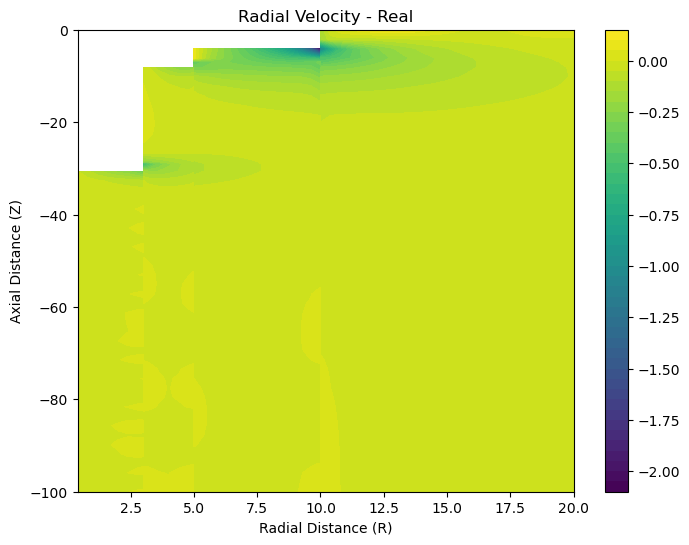

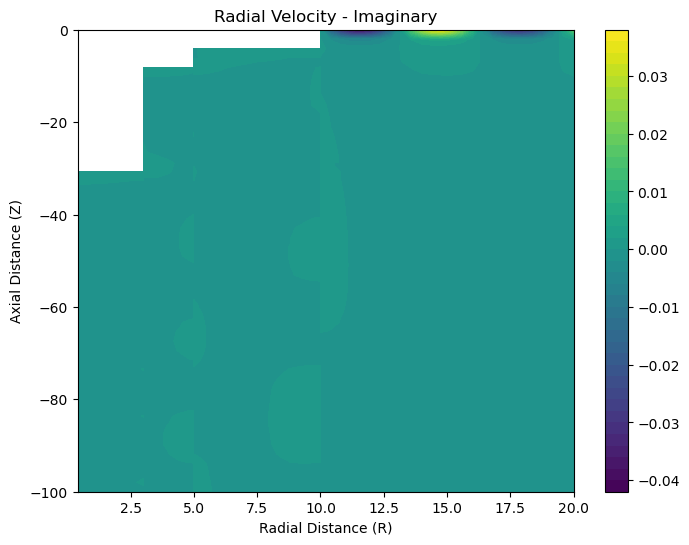

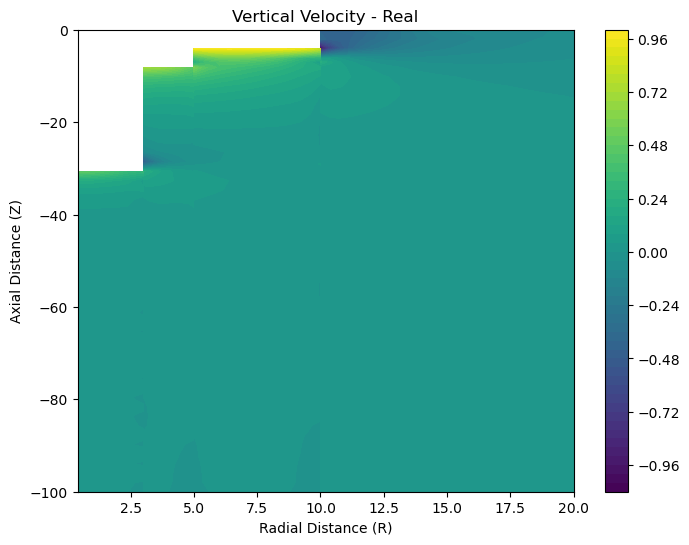

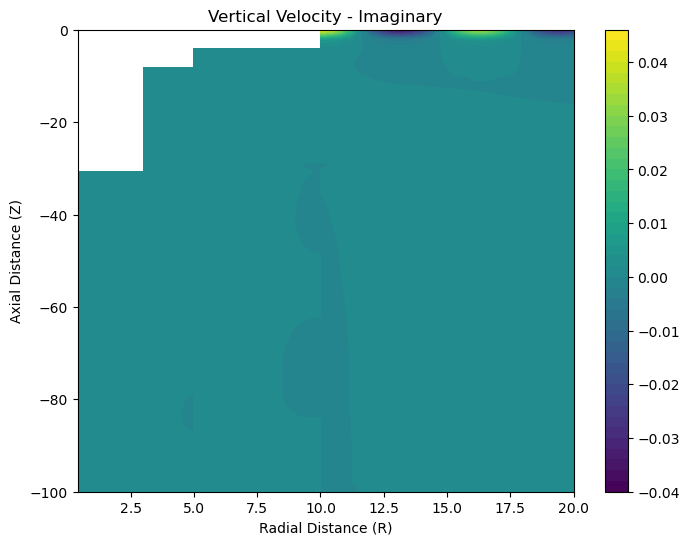

In [14]:
plot_potential(np.real(vr), R, Z, 'Radial Velocity - Real')
plot_potential(np.imag(vr), R, Z, 'Radial Velocity - Imaginary')
plot_potential(np.real(vz), R, Z, 'Vertical Velocity - Real')
plot_potential(np.imag(vz), R, Z, 'Vertical Velocity - Imaginary')

In [15]:
# Format Potential Matrix for Testing:
R, Z = make_R_Z(False, 50)

regions = []
regions.append((R <= a[0]) & (Z < -d[0]))
for i in range(1, boundary_count):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
regions.append(R > a[-1])

phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

for n in range(NMK[0]):
    temp_phiH = phi_h_n_inner_func(n, R[regions[0]], Z[regions[0]])
    phiH[regions[0]] = temp_phiH if n == 0 else phiH[regions[0]] + temp_phiH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_phiH = phi_h_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        phiH[regions[i]] = temp_phiH if m == 0 else phiH[regions[i]] + temp_phiH

for k in range(NMK[-1]):
    temp_phiH = phi_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    phiH[regions[-1]] = temp_phiH if k == 0 else phiH[regions[-1]] + temp_phiH

phi_p_i_vec = np.vectorize(phi_p_i)

phiP[regions[0]] = heaving[0] * phi_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    phiP[regions[i]] = heaving[i] * phi_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
phiP[regions[-1]] = 0

phi = phiH + phiP

nanregions = []
nanregions.append((R <= a[0]) & (Z > -d[0]))
for i in range(1, len(a)):
    nanregions.append((R > a[i-1]) & (R <= a[i]) & (Z > -d[i]))

In [16]:
def interpret_file(filename, omega): # comparison with Capytaine
    file_path = "test/data/" + filename + "-imag.csv"
    df = (pd.read_csv(file_path, header=None)).transpose()
    real_array = (df.to_numpy()) * (-1/omega)
        
    file_path = "test/data/" + filename + "-real.csv"
    df = (pd.read_csv(file_path, header=None)).transpose()
    imag_array = (df.to_numpy()) * (1/omega)

    return(real_array, imag_array)

def interpret_file2(filename):
    file_path = "test/data/" + filename + "-imag - matlab.csv"
    df = (pd.read_csv(file_path, header=None))
    #df_flipped = df.iloc[::-1].reset_index(drop=True)
    imag_array = df.to_numpy()
        
    file_path = "test/data/" + filename + "-real - matlab.csv"
    df = (pd.read_csv(file_path, header=None))
    #df_flipped = df.iloc[::-1].reset_index(drop=True)
    real_array = df.to_numpy()

    return(real_array, imag_array)

def plot_difference(title, R, Z, arr):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, arr, levels=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

# arguments: the name of the csv to compare with, an appropriately formatted potential array
# the threshold of closeness, appropriate R and Z, and omega to help with conversion
# tailored for 50x50 points (including nans), evenly spaced, twice the widest radius, and given height

def potential_comparison(filename, arr, threshold, R, Z, omega, nan_mask):

    real_arr, imag_arr = interpret_file(filename, omega)
    real_calc_arr = np.real(arr)
    imag_calc_arr = np.imag(arr)

    plot_potential(real_arr, R, Z, 'Capytaine Potential Real')
    plot_potential(real_calc_arr, R, Z, 'MEEM Potential Real')
    plot_potential(imag_arr, R, Z, 'Capytaine Potential Imaginary')
    plot_potential(imag_calc_arr, R, Z, 'MEEM Potential Imaginary')

    plot_potential(real_arr - real_calc_arr, R, Z, 'Real Potential Difference')
    plot_potential(imag_arr - imag_calc_arr, R, Z, 'Imag Potential Difference')

    raw_fraction_real = (real_arr - real_calc_arr)/real_arr
    raw_fraction_imag = (imag_arr - imag_calc_arr)/imag_arr

    fraction_real = np.where(abs(raw_fraction_real) < 0.1, raw_fraction_real, np.nan)
    fraction_imag = np.where(abs(raw_fraction_imag) < 1, raw_fraction_imag, np.nan)

    plot_potential(fraction_real, R, Z, 'Fractional Real Potential Difference')
    plot_potential(fraction_imag, R, Z, 'Fractional Imag Potential Difference')

    is_within_threshold_r = 1. * np.isclose(real_arr, np.real(arr), rtol=threshold, atol = 0.01)
    is_within_threshold_i = 1. * np.isclose(imag_arr, np.imag(arr), rtol=threshold, atol = 0.01)

    for i in range(len(nan_mask)):
        is_within_threshold_r[nan_mask[i]] = np.nan
        is_within_threshold_i[nan_mask[i]] = np.nan
        
    plot_difference("Real Match, " + str(100 * threshold) + "%", R, Z, is_within_threshold_r)
    plot_difference("Imaginary Match", R, Z, is_within_threshold_i)

    match_r = np.sum(np.isnan(is_within_threshold_r)) + np.sum(is_within_threshold_r == 1)
    match_i = np.sum(np.isnan(is_within_threshold_i)) + np.sum(is_within_threshold_i == 1)

    return (match_r, match_i, is_within_threshold_r, is_within_threshold_i)



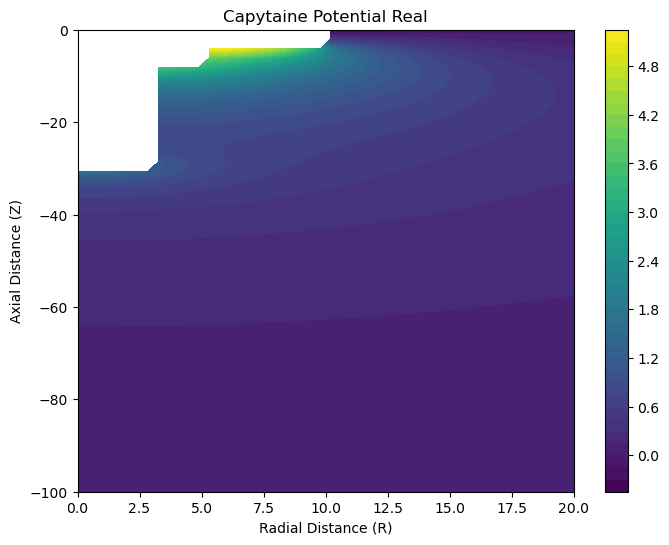

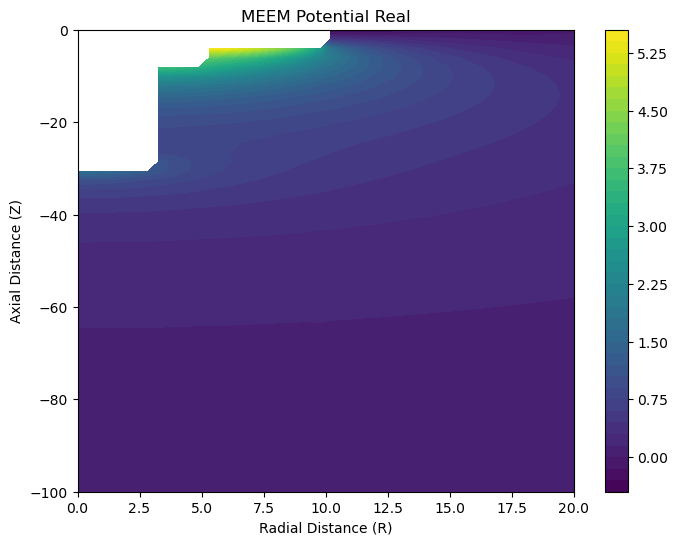

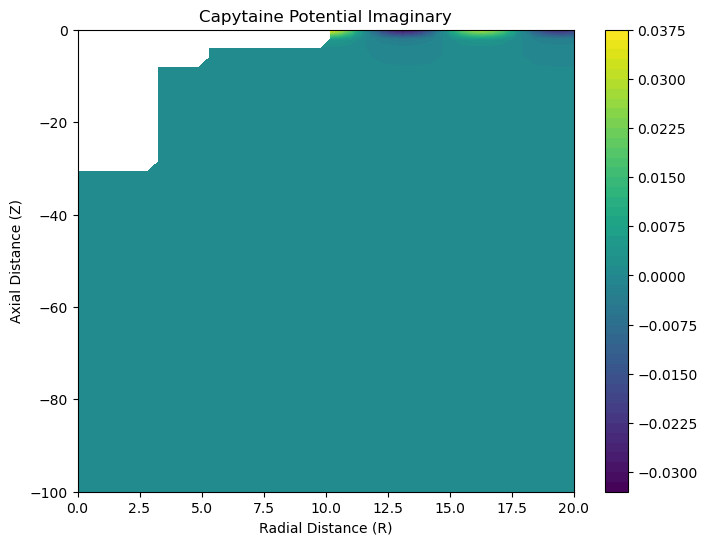

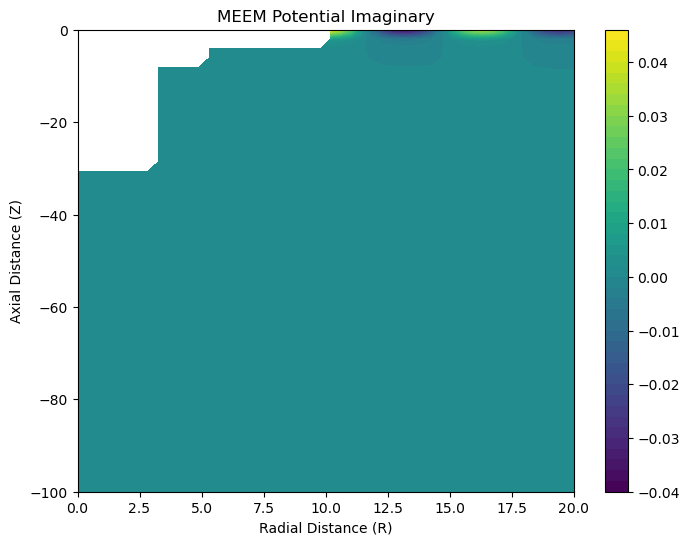

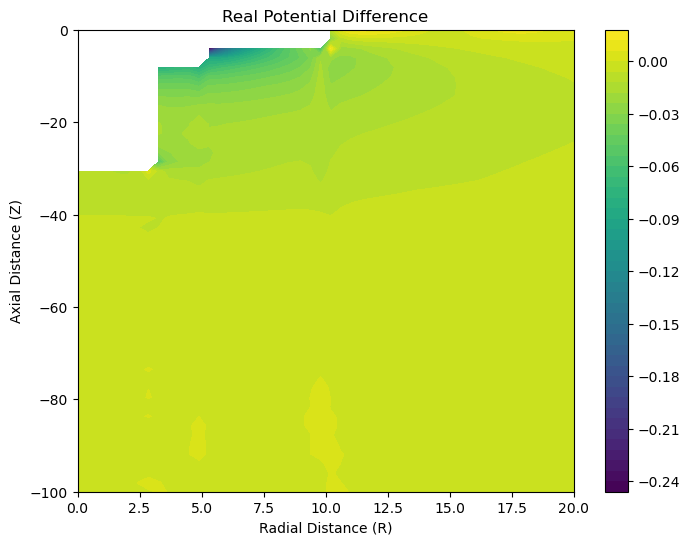

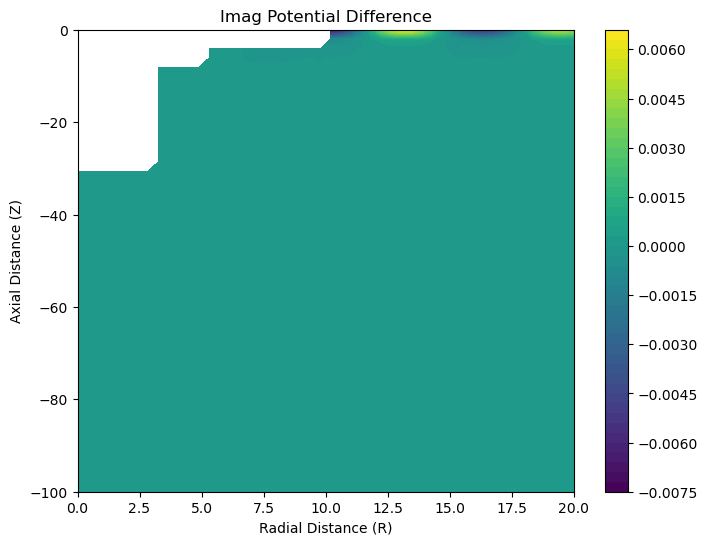

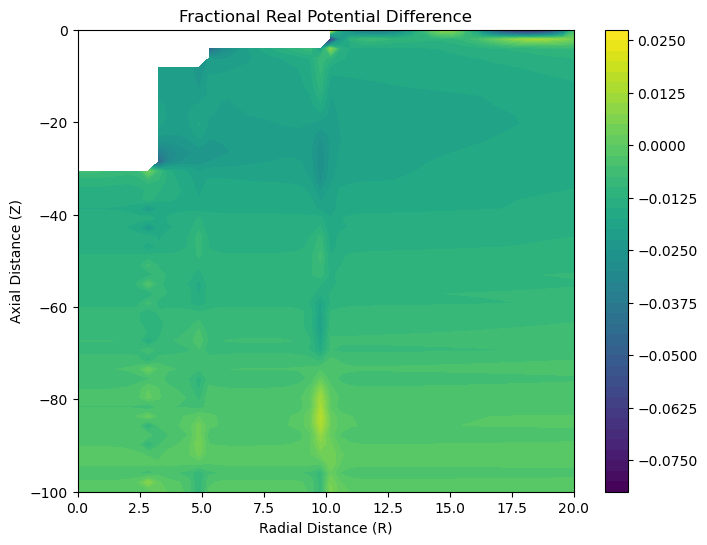

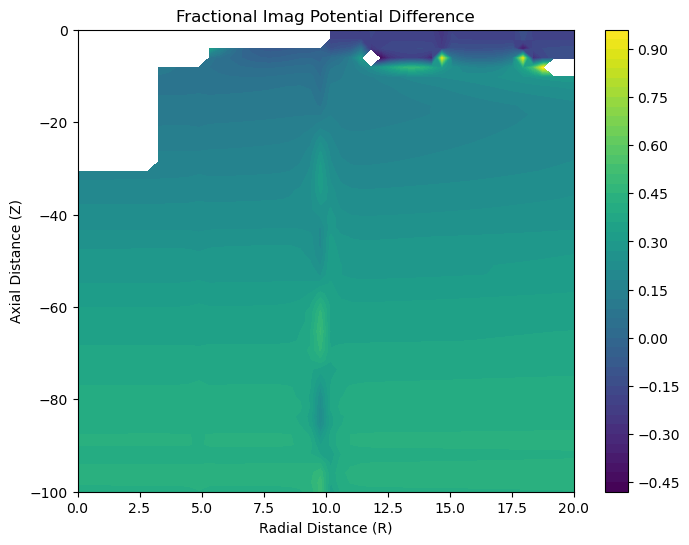

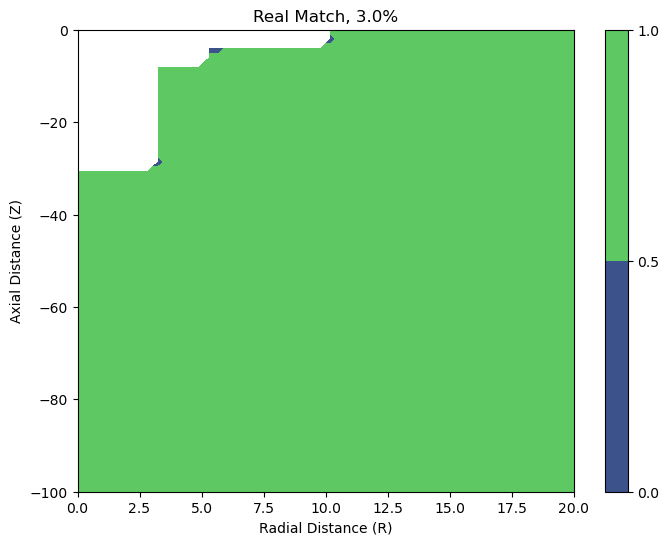

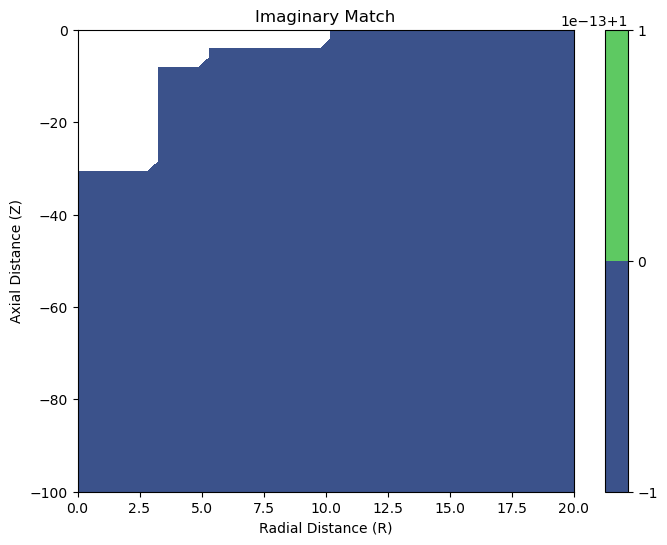

(2496,
 2500,
 array([[nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 array([[nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]))

In [17]:
potential_comparison("config2", phi, 0.01, R, Z, omega, nanregions)

In [18]:
# Run Test File

# %run test/multi_test.py

# After this is for workshopping test code, NOT intended to functionally do anything

In [19]:
def plot_velocity_stream(v_r, v_z, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.streamplot(R, Z, v_r, v_z, color='magenta', density=2)
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

def plot_velocity_quiver(v_r, v_z, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.quiver(R, Z, v_r, v_z, color='blue')
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

# These can't run with unevenly spaced sample points, but they're also not very important.
#plot_velocity_stream(np.real(vr), np.real(vz), R, Z, 'Real Velocity')
#plot_velocity_quiver(np.real(vr), np.real(vz), R, Z, 'Real Velocity')

In [20]:
# Run this code block for a quick visual of our results converted to the Capytaine conventions.
# Capytaine should output something that is off by a factor of (-) i * omega. The following graphs do that:
# Figure out why vrc factor is different from phic and vrz (no negative sign) (likely due to times i vs divide by i)

#phic = - phi * 1j * omega
#vrc = vr * 1j * omega
#vzc = - vz * 1j * omega

#R, Z = make_R_Z(False, 50) # phi was redefined into this coordinate array earlier
#plot_potential(np.real(phic), R, Z, 'Capytaine Potential Real')
#plot_potential(np.imag(phic), R, Z, 'Total Potential Imaginary')

#R, Z = make_R_Z(True, 50) # "sharp" coordinate array
#plot_potential(np.real(vrc), R, Z, 'Radial Velocity - Real') 
#plot_potential(np.imag(vrc), R, Z, 'Radial Velocity - Imaginary')
#plot_potential(np.real(vzc), R, Z, 'Vertical Velocity - Real')
#plot_potential(np.imag(vzc), R, Z, 'Vertical Velocity - Imaginary')


In [21]:
# Study Convergence, assume that every entry of NMK is 50.
# Strategy: Make large A matrices, b vector, then select submatrices/vectors
# Solve for hydro-coefficients like before
# Plot hydro-coefficients vs. coefficient count

def hydro_coeff_calc(s, blocks, C):
    hydro_terms = np.zeros((s * (blocks - 1)), dtype=complex)

    col = 0
    for n in range(s):
        hydro_terms[n] = int_R_1n(0, n)* C[n] * z_n_d(n)
    col += s
    for i in range(1, boundary_count):
        for m in range(s):
            hydro_terms[col + m] = int_R_1n(i, m)* C[col + m] * z_n_d(m)
            hydro_terms[col + s + m] = int_R_2n(i, m)* C[col + s + m] * z_n_d(m)
        col += 2 * s
    
    hydro_p_terms = np.zeros(boundary_count, dtype=complex)
    for i in range(boundary_count):
        hydro_p_terms[i] = heaving[i] * int_phi_p_i(i)
    
    hydro_coef =2*pi*(sum(hydro_terms) + sum(hydro_p_terms))
    hydro_coef_real = hydro_coef.real
    hydro_coef_imag = hydro_coef.imag/omega
    
    hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef
    
    return hydro_coef_nondim


hydro_nondim_real = []
hydro_nondim_imag = []

NMK_count = 100
blocks = 2 * boundary_count
for s in range(1, NMK_count + 1):
    alpha = np.zeros((blocks * s, blocks * s), dtype=complex)
    beta = np.zeros(blocks * s, dtype=complex)
    for rowblock in range(blocks):
        for i in range(s):
            beta[i + s * rowblock] = b[i + NMK_count * rowblock]
            for colblock in range(blocks):
                for j in range(s):
                    alpha[i + s * rowblock][j + s * colblock] = A[i + NMK_count * rowblock][j + NMK_count * colblock]
    C = linalg.solve(alpha,beta)
    hcnd = hydro_coeff_calc(s, blocks, C)
    hydro_nondim_real.append(hcnd.real)
    hydro_nondim_imag.append(hcnd.imag)


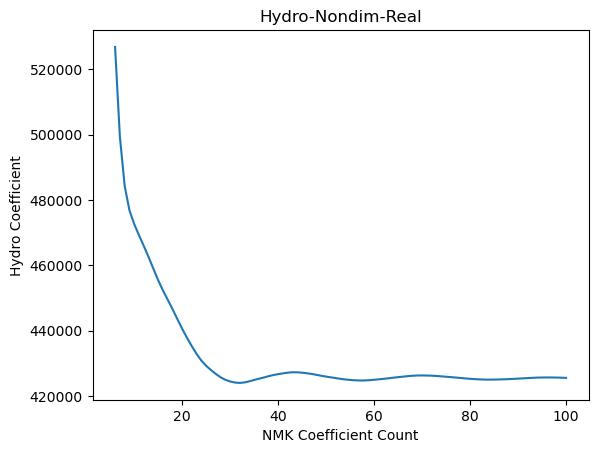

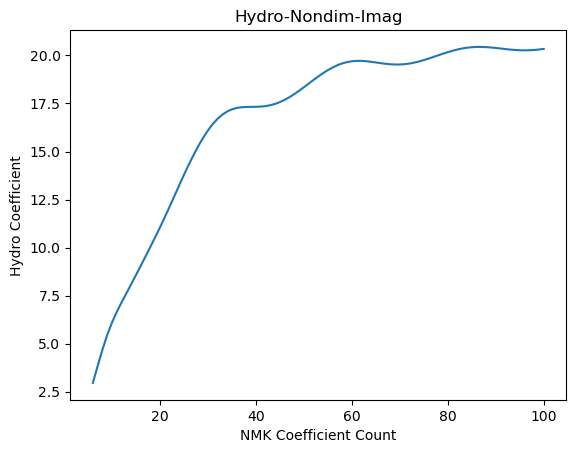

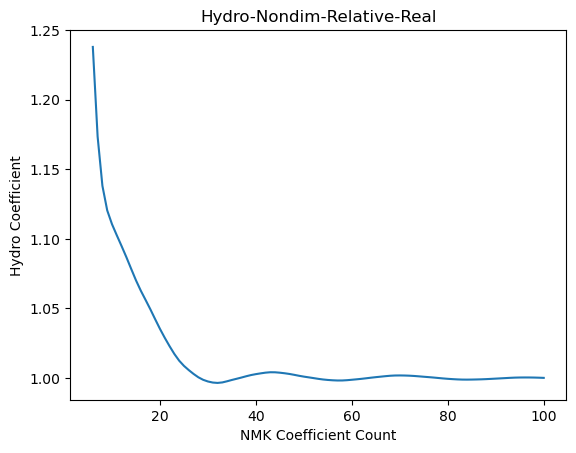

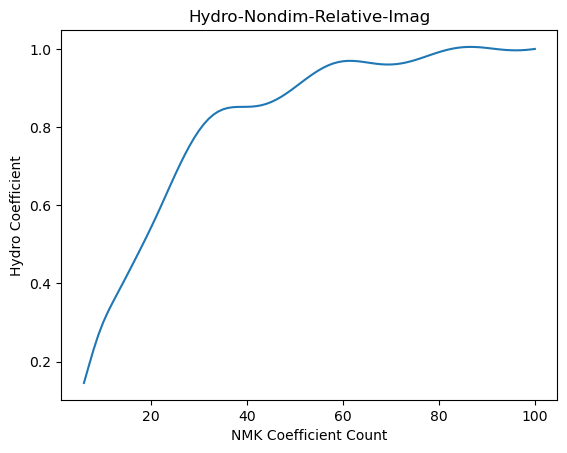

In [22]:
def plot_hydros(xs, ys, title):
    #plt.figure(figsize=(8, 6))
    plt.plot(xs, ys)
    plt.title(title)
    plt.xlabel('NMK Coefficient Count')
    plt.ylabel('Hydro Coefficient')
    plt.show()

xs = list(range(1, NMK_count + 1))
#plot_hydros(xs, hydro_nondim_real, "Hydro-Nondim-Real")
#plot_hydros(xs, hydro_nondim_imag, "Hydro-Nondim-Imag")

idealr = hydro_nondim_real[-1]
ideali = hydro_nondim_imag[-1]

relative_real = list(map(lambda x: (x/idealr), hydro_nondim_real))
relative_imag = list(map(lambda x: (x/ideali), hydro_nondim_imag))

#plot_hydros(xs, relative_real, "Hydro-Nondim-Relative-Real")
#plot_hydros(xs, relative_imag, "Hydro-Nondim-Relative-Imag")

#plot while removing most extreme initial values
plot_hydros(xs[5:], hydro_nondim_real[5:], "Hydro-Nondim-Real")
plot_hydros(xs[5:], hydro_nondim_imag[5:], "Hydro-Nondim-Imag")
plot_hydros(xs[5:], relative_real[5:], "Hydro-Nondim-Relative-Real")
plot_hydros(xs[5:], relative_imag[5:], "Hydro-Nondim-Relative-Imag")

In [23]:
# Refer to original MEEM file for some extra plotting functions.